In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import seaborn as sns
import imageio.v3 as iio
import os
import pathlib
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [3]:
exp_dir = "/home/julian/data/dmcp_experiments/middlebury/"
repr_errs = []
transforms = []
native_Ps = []
for sdir in pathlib.Path(exp_dir).glob("./*"):
    if not sdir.is_dir():
        continue
    repr_file = list(sdir.glob("reprErrs*"))[0]
    reprs = np.loadtxt(repr_file)
    repr_errs.append(reprs)

    trans_file = list(sdir.glob("transform*"))[0]
    trans = np.loadtxt(trans_file,delimiter=",")
    transforms.append(trans)

    P_file = list(sdir.glob("imP*"))[0]
    imP = np.loadtxt(P_file,delimiter=",")
    native_Ps.append(imP)

    cp_file = list(sdir.glob("cps*"))[0]


idxs = [4,5,6,7,8,16]
idxs = [str(i) for i in idxs]

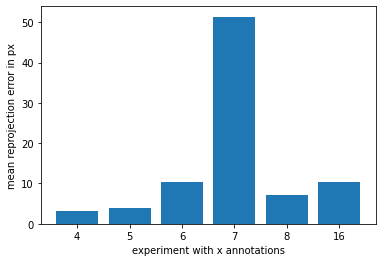

In [4]:
mean_repr_errs = [np.mean(re) for re in repr_errs]
%matplotlib inline
plt.figure()
plt.bar(idxs,mean_repr_errs)
plt.xlabel("experiment with x annotations")
plt.ylabel("mean reprojection error in px")
#plt.savefig("/home/julian/Downloads/middlebury_scaling_mean_repr_errs.eps")
plt.show()
#plt.gca().spines['left'].set_visible(False)

In [50]:
non_zero_repr_errs = [re[np.nonzero(re)] for re in repr_errs]
non_zero_repr_errs = non_zero_repr_errs
non_zero_repr_errs

non_zero_flatten = np.array([err for errs in non_zero_repr_errs for err in list(errs)]).astype(np.float32); non_zero_flatten
#np.percentile(non_zero_concat,0.90)

print(f"median {np.median(non_zero_flatten)}")
print(f"7 ann. errs {non_zero_repr_errs[3]}")

median 11.040000915527344
7 ann. errs [      8.66     207.33     136.47       7.10]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


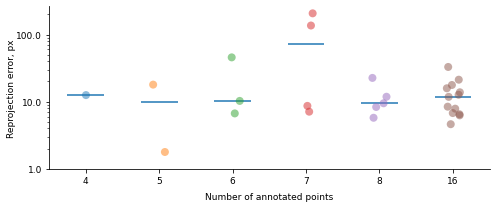

In [29]:

import colorcet as cc
data = non_zero_repr_errs
hlines = [np.median(e) for e in non_zero_repr_errs]
%matplotlib inline
plt.figure(figsize=(7,3))
#fig, ax = plt.subplots()

for i,med in enumerate(hlines):
    plt.hlines(med, i-0.25, i+0.25)

sns.stripplot(data=data,  edgecolor='none', jitter=True,
              alpha=0.5, size=8)

sns.despine(); plt.yscale('log')

plt.xticks(range(6),["4","5","6","7","8","16"], fontsize=9); #plt.xlim(-0.5,20.5)
plt.yticks(ticks=[1e0, 1e1, 1e2], labels=[1.0,10.0,100.0],
           fontsize=9);#plt.ylim(1.0,105)

plt.xlabel('Number of annotated points',fontsize=9, labelpad=7)
plt.ylabel('Reprojection error, px', fontsize=9, labelpad=0);


#date_x = np.arange(-0.2, 21, 3)
#import matplotlib.transforms as transforms
#trans = transforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
#for x, night in zip(date_x, ["4","5","6","7","8","16"]):
#    plt.text(x, -.235, night+f'\n(4)', fontsize=9,
#             multialignment='center',transform= trans)
#from matplotlib.ticker import FuncFormatter

plt.tight_layout()
plt.savefig('middlebury_scaling_reprojection.eps')
plt.show()

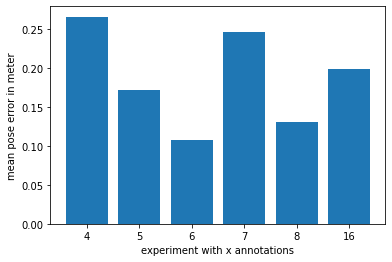

In [7]:
def pinhole_pose(P):
    pose_hat = la.null_space(P) / la.null_space(P)[-1]
    return pose_hat[:3].flatten()

world_poses = [pinhole_pose(native_Ps[i] @ la.inv(transforms[i])) for i in range(len(native_Ps))]

# error is distance to true position [0,0,0]
# pose errors are in mm(?!), we want m so divide by 10000.0
pose_errors = [la.norm(world_pose) / 1000 for world_pose in world_poses] 

plt.figure()
plt.bar(idxs, pose_errors )
plt.xlabel("experiment with x annotations")
plt.ylabel("mean pose error in meter")
#plt.savefig("/home/julian/Downloads/middlebury_scaling_pose_errs.eps")
plt.show()

In [8]:
mesh = pv.read("/home/julian/data/middlebury/middlebury_mesh.ply")

wpMesh = pv.PolyData(np.array(world_poses))

pl = pv.Plotter(notebook=False)
pl.add_mesh(mesh,point_size=1,scalars="RGB",rgb=True,pickable=True)
pl.add_mesh(wpMesh,color="blue",render_points_as_spheres=True,point_size=15)
pl.add_mesh(pv.Sphere(radius=250,center=[0,0,0]),color="white")
pl.show()

In [9]:
mean_pose_error = np.mean(pose_errors)
print(f"mean pose error {round(mean_pose_error,2)}m")

mean pose error 0.19m
